In [175]:
# SECOND PROJECT

# Assumptions ----------------------------------------------#
#   For both the csv files column X is the list of times in the format YYYY-MM-DD
# -----------------------------------------------------------#

# Model parameters ----------------------------------#
listOfMToTest = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

timeLimit = 3600 # Timeout for optimization 2.
RUNOPTIMISATION = False # If this is false; then the resultsFile has to exist!
SAVERESULTSTOFILE = False 
resultsFile = "results.json"
# ---------------------------------------------------#

inSampleFile = "stocks2019.csv"
outSampleFile = "stocks2020.csv"

# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
import sys
import os
import json


# Importing the dataset
inSampleData = pd.read_csv(inSampleFile, parse_dates=['X'])
outSampleData = pd.read_csv(outSampleFile, parse_dates=['X'])


In [176]:
inSampleData.head(3)

,X,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,2019-01-02,6360.870117,46.350380,224.570007,18.830000,98.050003,202.119995,1054.680054,1045.849976,1539.130005,...,27.590000,247.970001,147.759995,107.364159,164.080002,63.920757,159.740005,36.312473,46.041862,84.600266
1,2019-01-03,6147.129883,44.704514,215.699997,17.049999,100.209999,184.779999,1025.469971,1016.059998,1500.280029,...,26.959999,243.360001,142.589996,104.083450,163.729996,63.253742,154.020004,33.835327,45.860447,81.414970
2,2019-01-04,6422.669922,46.488358,226.190002,19.000000,106.000000,186.710007,1078.069946,1070.709961,1575.390015,...,28.549999,255.029999,148.970001,108.678413,172.699997,65.358139,163.350006,35.268467,46.309223,85.184715


In [177]:
outSampleData.head(3)

,X,NDX,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
0,2020-01-02,8872.219727,58.266792,334.429993,49.099998,107.839996,283.679993,1368.680054,1367.369995,1898.010010,...,36.970001,254.550003,196.729996,150.376770,219.449997,57.253372,167.460007,64.771545,61.184597,100.399811
1,2020-01-03,8793.900391,58.286655,331.809998,48.599998,106.410004,280.440002,1361.520020,1360.660034,1874.969971,...,36.180000,250.169998,200.880005,151.839554,217.979996,57.253372,168.440002,63.774597,61.478848,98.088585
2,2020-01-06,8848.519531,59.349670,333.709991,48.389999,106.580002,285.880005,1397.810059,1394.209961,1902.880005,...,35.689999,250.949997,202.740005,152.187836,224.029999,57.747601,169.490005,62.550629,61.390568,96.044044


In [178]:
# For both the csv files column X is the list of times in the format YYYY-MM-DD. Set the index to be this column
inSampleData = inSampleData.set_index('X')
outSampleData = outSampleData.set_index('X')

# REMOVE THIS LINE ____________________________________________________________________#
# KEEP ONLY 30 columns because gurobi free license is size limited
# inSampleData = inSampleData.iloc[:, : 6]
# outSampleData = outSampleData.iloc[:, : 6]
#______________________________________________________________________________________#


# Number of stocks = number of columns - 1
n = len(inSampleData.columns) - 1
print("There are " + str(n) + " stocks in the index.")

There are 100 stocks in the index.


In [179]:
def whichStocksToInclude(correlationMat, m):
    # Input: correlation matrix, number of stocks to include
    # Output: list of stocks to include
    # ---------------------------------------------------#

    model = gp.Model("Which stocks to include")
    model.setParam('OutputFlag', False)

    # Add a matrix called of X of binary variables. Of size n x n
    X = model.addMVar(shape=(n,n), vtype=gp.GRB.BINARY, name="X")
    # Add a vector of binary variables called y of size n
    y = model.addMVar(shape=n, vtype=gp.GRB.BINARY, name="y")


    # Objective is to maximize product of correl * x over the entire matrix X
    objectiveExpr = []
    for i in range(n):
        for j in range(n):
            objectiveExpr.append(correlationMat.iloc[i,j] * X[i,j])

    model.setObjective(gp.quicksum(objectiveExpr), gp.GRB.MAXIMIZE)

    # Add constraints

    # 1 ----------------------------------------------------#
    # Sum of y = m
    model.addConstr(gp.quicksum(y) == m)
    # ------------------------------------------------------#


    # 2 ----------------------------------------------------#
    # For every column in X, sum = 1
    for i in range(n):
        model.addConstr(gp.quicksum(X[i,:]) == 1)
    # ------------------------------------------------------#


    # 3 ----------------------------------------------------#
    # For every column in X
    for i in range(n):
        # For every row variable in X, x[i,j] <= y[j]
        for j in range(n):
            model.addConstr(X[i,j] <= y[j])
    # ------------------------------------------------------#
    

    # Optimize ---------------------------------------------#
    model.optimize()
    # ------------------------------------------------------#

    return [correlationMat.columns[i] for i in range(n) if y.x[i] == 1], y.x


In [180]:
def calculatePortfolioWeights(returnsDf, indexDf):
    # Input: dataframe of returns (should only contain the stocks to include), dataframe of index returns
    # Output: list of portfolio weights
    # ---------------------------------------------------#

    model = gp.Model("Calculate portfolio weights")
    model.setParam('OutputFlag', False)

    # Add a vector of continuous variables called w of size m
    w = model.addMVar(shape=len(returnsDf.columns), vtype=gp.GRB.CONTINUOUS, name="w")

    # Add a vector of continuous variables called z of size == number of rows in returnsDf
    z = model.addMVar(shape=len(returnsDf), vtype=gp.GRB.CONTINUOUS, name="z")

    # Objective is to minimize sum of z
    model.setObjective(gp.quicksum(z), gp.GRB.MINIMIZE)

    # Add constraints

    for i in range(len(returnsDf)):
        # For every row in returnsDf, sum of w * returns = z
        totalReturns = []
        for j in range(len(returnsDf.columns)):
            totalReturns.append(w[j] * returnsDf.iloc[i,j])

        indexReturn = indexDf.iloc[i]
        model.addConstr(gp.quicksum(totalReturns) - indexReturn <= z[i])
        model.addConstr(- gp.quicksum(totalReturns) + indexReturn <= z[i])
    
    # Weights sum to 1
    model.addConstr(gp.quicksum(w) == 1)


    # Optimize ---------------------------------------------#
    model.optimize()
    # ------------------------------------------------------#

    return w.x


In [181]:
def calculateReturnsDf(data):
    # Input: dataframe of prices
    # Output: dataframe of returns
    # ---------------------------------------------------#

    newDf = data.apply(lambda x: x.pct_change()).copy()
    newDf.dropna(inplace=True)
    return newDf

In [182]:
def calculateCorrelationMatrix(returnsDf, dropIndex = True):
    # Input: dataframe of returns
    # Output: correlation matrix
    # ---------------------------------------------------#

    if(dropIndex):
        # Drop the first column
        returnsDf = returnsDf.iloc[:,1:]

    return returnsDf.corr()


In [183]:
def calculateTrackingError(weightsDf, returnsDf, indexReturnsDf):
    # Input: dataframe of weights, dataframe of returns, dataframe of index returns
    # Output: tracking error
    # ---------------------------------------------------#

    def calculateTrackingErrorForOneDay(weightsDf, returns, indexReturn):
        totalReturn = 0
        returnToday = returns
        prod = weightsDf.join(returnToday, how='inner')
        prod = prod.apply(lambda x: x[0] * x[1], axis=1)
        totalReturn = prod.sum()


        return abs(totalReturn - indexReturn)

    trackingError = 0

    for i in range(len(returnsDf)):
        trackingError += calculateTrackingErrorForOneDay(weightsDf, returnsDf.iloc[i], indexReturnsDf.iloc[i])

    return trackingError
        


In [184]:
def minimizeUsingTheBigMConstraint(returnsDf, indexDf, m):
    # Input: dataframe of returns (of stocks only, do not include index), dataframe of index returns, number of stocks to include
    # Output: list of stocks to include, list of portfolio weights, tracking error
    # ---------------------------------------------------#

    model = gp.Model("Calculate portfolio weights using Big-M")
    model.setParam('OutputFlag', False)

    # Add a vector of continuous variables called w of size m
    w = model.addMVar(shape=len(returnsDf.columns), vtype=gp.GRB.CONTINUOUS, name="w")

    # Add a vector of continuous variables called z of size == number of rows in returnsDf
    z = model.addMVar(shape=len(returnsDf), vtype=gp.GRB.CONTINUOUS, name="z")

    # Add a vector of binary variables called y of size m
    y = model.addMVar(shape=len(returnsDf.columns), vtype=gp.GRB.BINARY, name="y")

    # Objective is to minimize sum of z
    model.setObjective(gp.quicksum(z), gp.GRB.MINIMIZE)

    # Add constraints

    for i in range(len(returnsDf)):
        # For every row in returnsDf, sum of w * returns = z
        totalReturns = []
        for j in range(len(returnsDf.columns)):
            totalReturns.append(w[j] * returnsDf.iloc[i,j])

        indexReturn = indexDf.iloc[i]
        model.addConstr(gp.quicksum(totalReturns) - indexReturn <= z[i])
        model.addConstr(- gp.quicksum(totalReturns) + indexReturn <= z[i])
    
    # Weights sum to 1
    model.addConstr(gp.quicksum(w) == 1)

    # Sum of y = m
    model.addConstr(gp.quicksum(y) == m)

    # Add big-M constraints
    M = 1
    for i in range(len(returnsDf.columns)):
        model.addConstr(w[i] <= M * y[i])

    # Optimize ---------------------------------------------#
    # Add a timelimit of 10 seconds
    model.setParam('TimeLimit', timeLimit)
    model.optimize()
    # ------------------------------------------------------#

    # Returns names of non zero weight stocks
    return [returnsDf.columns[i] for i in range(len(returnsDf.columns)) if w.x[i] > 0], [x for x in w.x if x != 0]

In [185]:
def calculatePortfolioReturns(weightsDf, returnsDf):
    # Input: dataframe of weights, dataframe of returns
    # Output: dataframe of portfolio returns
    # ---------------------------------------------------#

    newDf = pd.DataFrame(columns=['Portfolio Returns'])

    for i in range(len(returnsDf)):
        totalReturn = 0
        # Take product of weights and returns
        returnToday = returnsDf.iloc[i]
        prod = weightsDf.join(returnToday, how='inner')
        prod = prod.apply(lambda x: x[0] * x[1], axis=1)
        totalReturn = prod.sum()
        
        # Terminate program execution
        newDf.loc[returnsDf.index[i]] = totalReturn

    return newDf

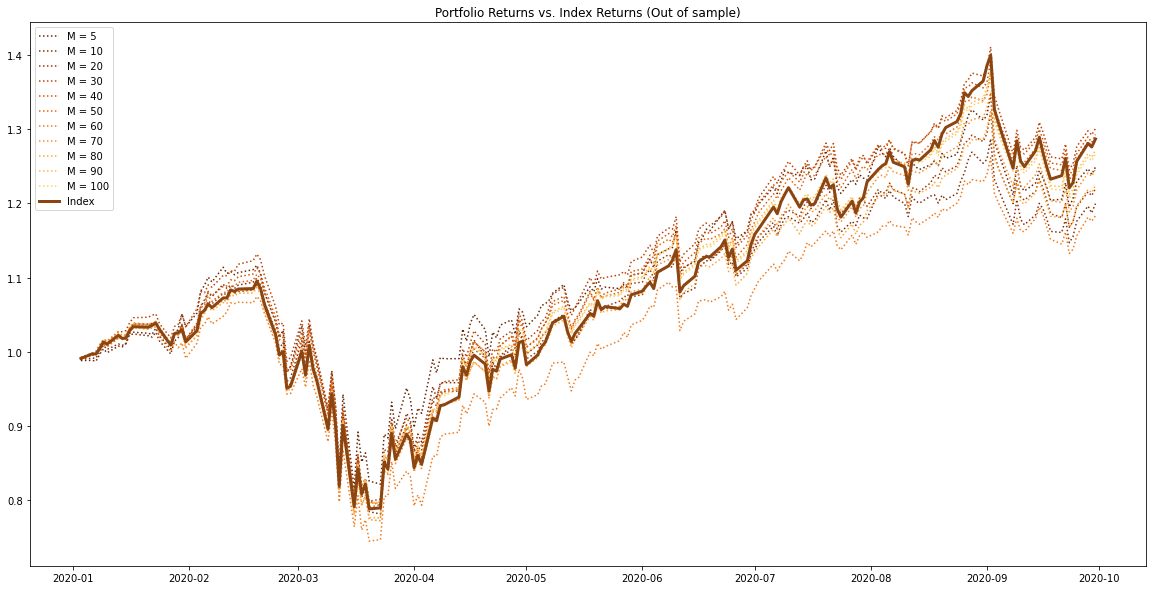

In [186]:

trackingErrors = []
trackingErrorsInSample = []

# Make one subplot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Calculate out of sample returns
outOfSampleReturnsDfOg = calculateReturnsDf(outSampleData)
outOfSampleIndexReturnsDf = outSampleData.iloc[:,0].pct_change().dropna(inplace=False)



# Coloring
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrBr')
colors = [cmap(i) for i in np.linspace(0, 1, len(listOfMToTest) + 5)]
colors = colors[::-1]
ax.set_prop_cycle(color=colors)

# Test all M
for testM in listOfMToTest:
    m = testM
    
    # Get which stocks to include
    returnsDf = calculateReturnsDf(inSampleData)
    correlationMatrix = calculateCorrelationMatrix(returnsDf, dropIndex = True)
    stocksToInclude, indexesOfStocksToInclude = whichStocksToInclude(correlationMatrix, m)

    # Calculate the weights of the portfolio
    returnsOfStocksToInclude = returnsDf[stocksToInclude]
    indexReturns = inSampleData.iloc[:,0].pct_change().dropna(inplace=False)
    weights = calculatePortfolioWeights(returnsOfStocksToInclude, indexReturns)
    weightsDf = pd.DataFrame(weights, index=stocksToInclude, columns=["Weights"])

    # Calculate out of sample stats using the weights we just got

    # Tracking error: 
    outOfSampleReturnsDf = outOfSampleReturnsDfOg[stocksToInclude]
    trackingError = calculateTrackingError(weightsDf, outOfSampleReturnsDf, outOfSampleIndexReturnsDf)
    trackingErrors.append(trackingError)

    # Tracking error in-sample:
    inSampleTrackingError = calculateTrackingError(weightsDf, returnsOfStocksToInclude, indexReturns)
    trackingErrorsInSample.append(inSampleTrackingError)
    

    # Portfolio returns:
    outSamplePortfolioReturns = calculatePortfolioReturns(weightsDf, outOfSampleReturnsDf)
    outSamplePortfolioReturns = outSamplePortfolioReturns + 1
    outSamplePortfolioReturns['Portfolio Prices'] = outSamplePortfolioReturns.cumprod()

    ax.plot(outSamplePortfolioReturns['Portfolio Prices'], ":", label="M = " + str(m))

# Plot the index
newOutOfSampleIndexReturnsDf = outOfSampleIndexReturnsDf + 1
outOfSampleIndexPrices = newOutOfSampleIndexReturnsDf.cumprod()
plt.plot(outOfSampleIndexPrices, label="Index", color="saddlebrown", linewidth=3)
plt.title("Portfolio Returns vs. Index Returns (Out of sample)")


plt.legend()

In [187]:
# Make a df of tracking errors
trackingErrorsDf = pd.DataFrame(trackingErrors, index=listOfMToTest, columns=["Tracking Error Out of Sample"])
trackingErrorsDf.index.name = "M"

display(trackingErrorsDf)

# Make a df of tracking errors in sample
trackingErrorsInSampleDf = pd.DataFrame(trackingErrorsInSample, index=listOfMToTest, columns=["Tracking Error In Sample"])
trackingErrorsInSampleDf.index.name = "M"

display(trackingErrorsInSampleDf)

,Tracking Error Out of Sample
M,
5,0.869670
10,0.831317
20,0.652338
30,0.549085
40,0.587312
50,0.581148
60,0.819424
70,0.402497
80,0.386431


,Tracking Error In Sample
M,
5,0.789178
10,0.686533
20,0.478836
30,0.418015
40,0.370517
50,0.332540
60,0.344890
70,0.169824
80,0.147683


In [188]:
#Test minimizeUsingTheBigMConstraint
returnsDf = calculateReturnsDf(inSampleData).iloc[:,1:]
indexDf = inSampleData.iloc[:,0].pct_change().dropna(inplace=False)


data = []

if(RUNOPTIMISATION):
    for m in listOfMToTest:
        stocksToInclude, weights = minimizeUsingTheBigMConstraint(returnsDf, indexDf, m)
        print("M = " + str(m))
        d = {
            'm': m,
            'stocksToInclude': stocksToInclude,
            'weights': weights
        }
        
        data.append(d)

        if(SAVERESULTSTOFILE):
            with open(resultsFile, 'w') as outfile:
                json.dump(data, outfile)
elif(os.path.exists(resultsFile)):
    with open(resultsFile) as f:
        data = json.load(f)



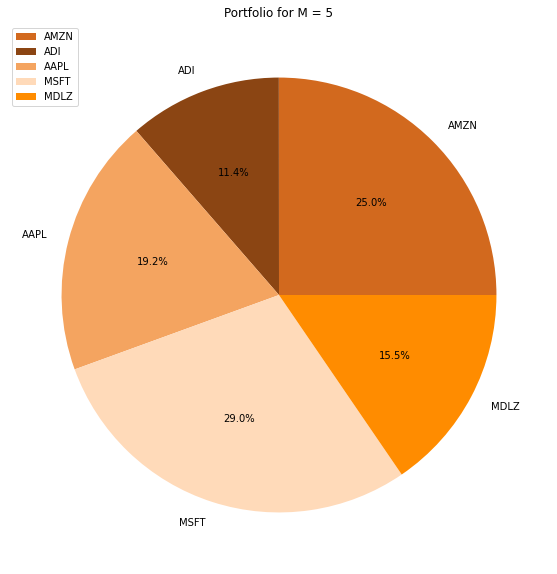

In [189]:
# Make a pie chart for M = 5

m_5_data = data[0]

# make a df of the weights
weightsDf = pd.DataFrame(m_5_data['weights'], index=m_5_data['stocksToInclude'], columns=["Weights"])

# Make a pie chart of weightsDf
plt.figure(figsize=(10,10))
plt.title("Portfolio for M = " + str(m_5_data['m']))
colors = ['chocolate', 'saddlebrown', 'sandybrown', 'peachpuff', 'darkorange']
plt.pie(weightsDf['Weights'], labels=weightsDf.index, autopct='%1.1f%%', colors=colors)
plt.legend()
plt.show()

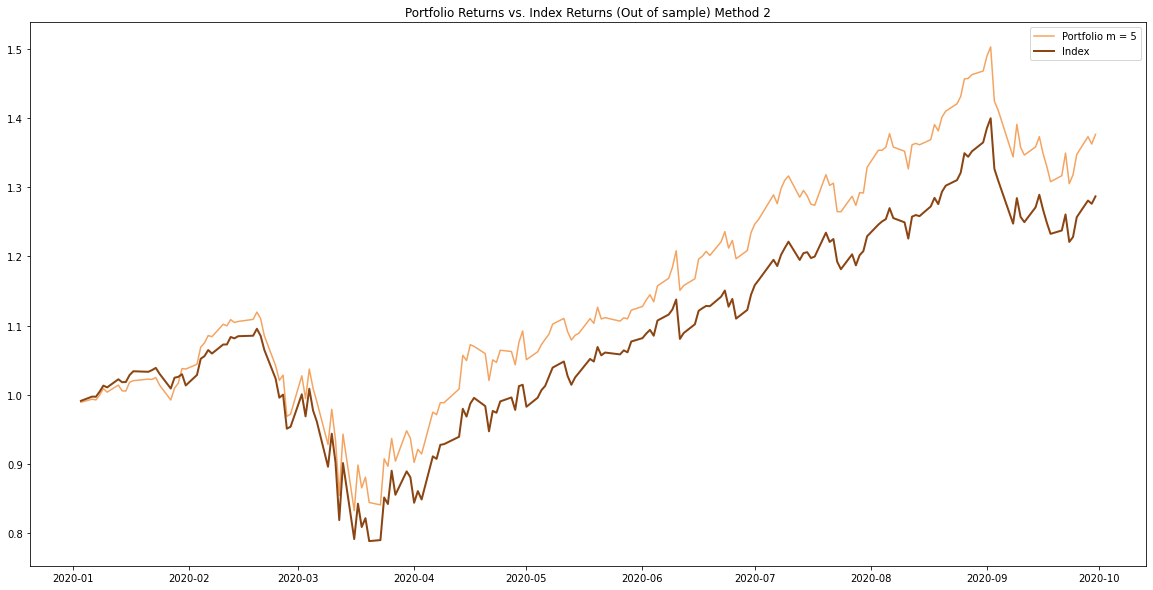

In [190]:
# PLOT THE m = 5 portfolio returns

# Make a plot of the portfolio returns
outOfSampleReturnsDf = calculateReturnsDf(outSampleData).iloc[:,1:]
outOfSampleReturnsDf = outOfSampleReturnsDf[m_5_data['stocksToInclude']]
outOfSampleIndexReturnsDf = outSampleData.iloc[:,0].pct_change().dropna(inplace=False)

outSamplePortfolioReturns = calculatePortfolioReturns(weightsDf, outOfSampleReturnsDf)
outSamplePortfolioReturns = outSamplePortfolioReturns + 1
outSamplePortfolioReturns['Portfolio Prices'] = outSamplePortfolioReturns.cumprod()

plt.figure(figsize=(20,10))
plt.plot(outSamplePortfolioReturns['Portfolio Prices'], label="Portfolio m = 5", c= "sandybrown")
plt.title("Portfolio Returns vs. Index Returns (Out of sample) Method 2")

newOutOfSampleIndexReturnsDf = outOfSampleIndexReturnsDf + 1
outOfSampleIndexPrices = newOutOfSampleIndexReturnsDf.cumprod()
plt.plot(outOfSampleIndexPrices, label="Index", color="saddlebrown", linewidth=2)
plt.legend()


,Tracking Error Method 2 Out of Sample
5,0.591398
10,0.476025
20,0.382244
30,0.363436
40,0.275842
50,0.263880
60,0.256302
70,0.251919
80,0.249124
90,0.249943


,Tracking Error Method 2 In Sample
5,0.499259
10,0.298885
20,0.163758
30,0.108988
40,0.078576
50,0.063138
60,0.052200
70,0.047552
80,0.045227
90,0.044911


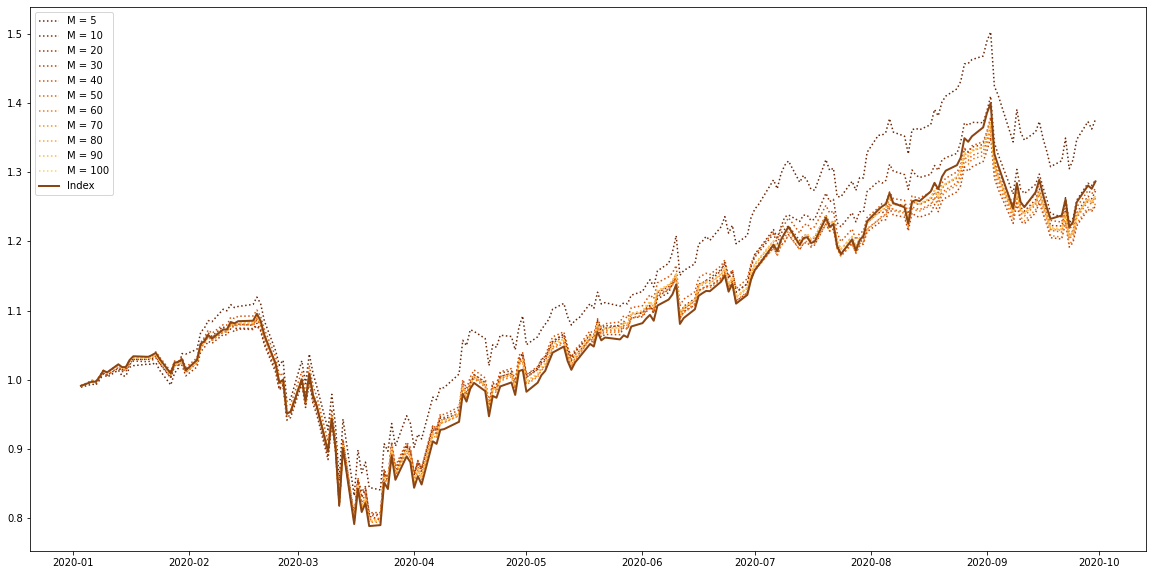

In [191]:
trackingErrors = []
trackingErrorsInSample = []


# Calculate out of sample returns
outOfSampleReturnsDfOg = calculateReturnsDf(outSampleData)
outOfSampleIndexReturnsDf = outSampleData.iloc[:,0].pct_change().dropna(inplace=False)


# Make one subplot
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Coloring
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrBr')
colors = [cmap(i) for i in np.linspace(0, 1, len(listOfMToTest) + 5)]
colors = colors[::-1]
ax.set_prop_cycle(color=colors)

# Make a df of tracking errors
for i, m in enumerate(listOfMToTest):
    m_data = data[i]

    # Calculate out sample tracking error
    weightsDf = pd.DataFrame(m_data['weights'], index=m_data['stocksToInclude'], columns=["Weights"])
    outOfSampleReturnsDf = calculateReturnsDf(outSampleData).iloc[:,1:]
    outOfSampleReturnsDf = outOfSampleReturnsDf[m_data['stocksToInclude']]

    trackingError = calculateTrackingError(weightsDf, outOfSampleReturnsDf, outOfSampleIndexReturnsDf)

    # Calculate in sample tracking error
    inSampleReturnsDf = calculateReturnsDf(inSampleData).iloc[:,1:]
    inSampleReturnsDf = inSampleReturnsDf[m_data['stocksToInclude']]
    inSampleIndexReturnsDf = inSampleData.iloc[:,0].pct_change().dropna(inplace=False)

    inSampleTrackingError = calculateTrackingError(weightsDf, inSampleReturnsDf, inSampleIndexReturnsDf)

    trackingErrors.append(trackingError)
    trackingErrorsInSample.append(inSampleTrackingError)

    # Portfolio returns:
    outSamplePortfolioReturns = calculatePortfolioReturns(weightsDf, outOfSampleReturnsDf)
    outSamplePortfolioReturns = outSamplePortfolioReturns + 1
    outSamplePortfolioReturns['Portfolio Prices'] = outSamplePortfolioReturns.cumprod()

    ax.plot(outSamplePortfolioReturns['Portfolio Prices'], ":", label="M = " + str(m))
    


# Plot the index
newOutOfSampleIndexReturnsDf = outOfSampleIndexReturnsDf + 1
outOfSampleIndexPrices = newOutOfSampleIndexReturnsDf.cumprod()
ax.plot(outOfSampleIndexPrices, label="Index", color="saddlebrown", linewidth=2)

# Plot the legend
ax.legend()


trackingErrorsDf2 = pd.DataFrame(trackingErrors, index=listOfMToTest, columns=["Tracking Error Method 2 Out of Sample"])
display(trackingErrorsDf2)

trackingErrorsInSampleDf2 = pd.DataFrame(trackingErrorsInSample, index=listOfMToTest, columns=["Tracking Error Method 2 In Sample"])
display(trackingErrorsInSampleDf2)

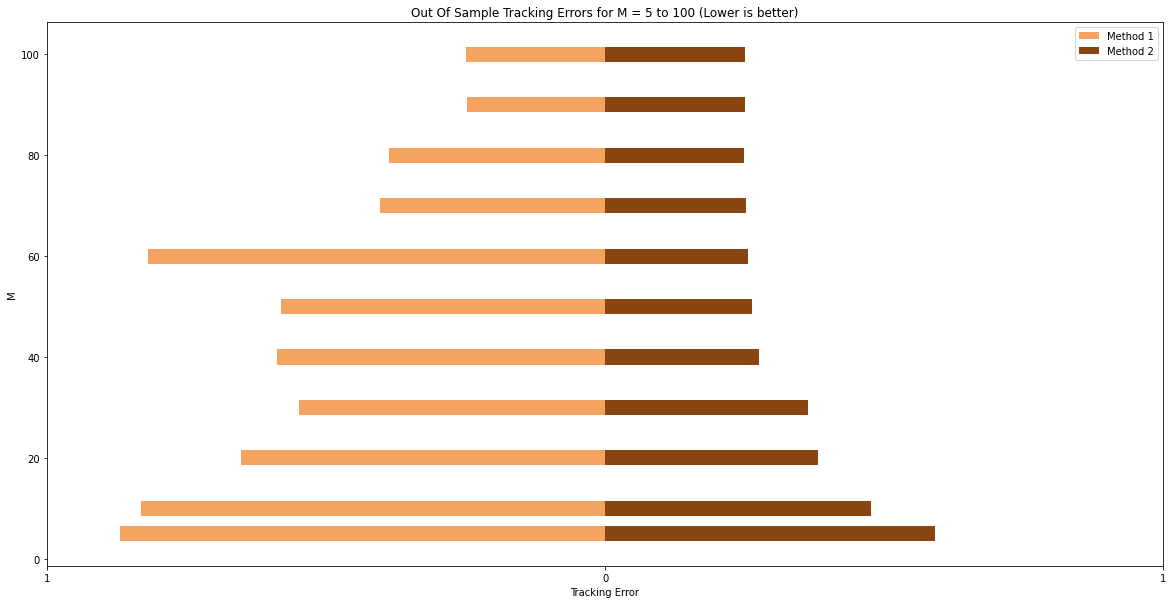

,Method 1,Method 2
M,,
5,0.869670,0.591398
10,0.831317,0.476025
20,0.652338,0.382244
30,0.549085,0.363436
40,0.587312,0.275842
50,0.581148,0.263880
60,0.819424,0.256302
70,0.402497,0.251919
80,0.386431,0.249124


In [192]:
# Merge tracking error df and tracking error df 2 and comapare them using a vertical bar chart
trackingErrorsDfMerged = trackingErrorsDf.merge(trackingErrorsDf2, left_index=True, right_index=True)
trackingErrorsDfMerged.columns = ["Method 1", "Method 2"]
trackingErrorsDfMerged

# Plot the tracking errors using horizontal bar chart with y axis in the middle
plt.figure(figsize=(20,10))
plt.title("Out Of Sample Tracking Errors for M = 5 to 100 (Lower is better)")
plt.barh(trackingErrorsDfMerged.index, -trackingErrorsDfMerged['Method 1'], label="Method 1", height=3, color="sandybrown")
plt.barh(trackingErrorsDfMerged.index, trackingErrorsDfMerged['Method 2'], label="Method 2", height=3, color="saddlebrown")
plt.legend()
plt.xlim(-1, 1)

# xticks don't display negative values
plt.xticks([-1, 0, 1], ["1", "0", "1"])
plt.xlabel("Tracking Error")
plt.ylabel("M")
plt.show()

trackingErrorsDfMerged

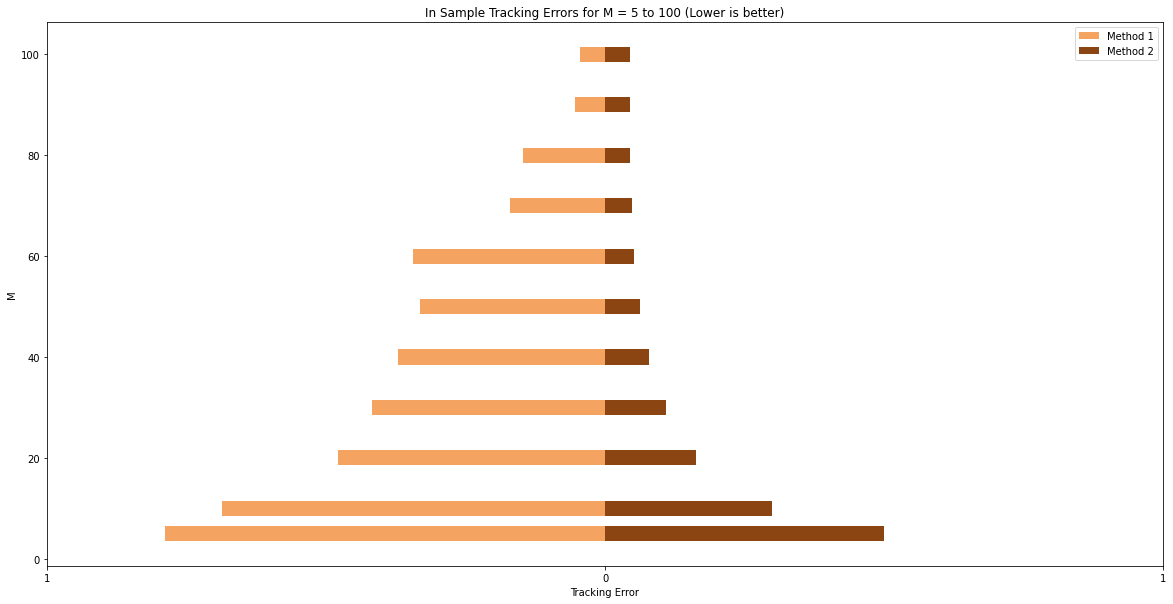

In [193]:
# Tracking errors in sample
trackingErrorsInSampleDfMerged = trackingErrorsInSampleDf.merge(trackingErrorsInSampleDf2, left_index=True, right_index=True)
trackingErrorsInSampleDfMerged.columns = ["Method 1", "Method 2"]
# Plot the tracking errors using horizontal bar chart with y axis in the middle
plt.figure(figsize=(20,10))
plt.title("In Sample Tracking Errors for M = 5 to 100 (Lower is better)")
plt.barh(trackingErrorsInSampleDfMerged.index, -trackingErrorsInSampleDfMerged['Method 1'], label="Method 1", height=3, color="sandybrown")
plt.barh(trackingErrorsInSampleDfMerged.index, trackingErrorsInSampleDfMerged['Method 2'], label="Method 2", height=3, color="saddlebrown")
plt.legend()
plt.xlim(-1, 1)

# xticks don't display negative values
plt.xticks([-1, 0, 1], ["1", "0", "1"])
plt.xlabel("Tracking Error")
plt.ylabel("M")
plt.show()



In [194]:
# Correlation of our recommended prices with the index (m = 60; Method 2)
m_data = data[listOfMToTest.index(60)]

# Calculate portfolio returns
weightsDf = pd.DataFrame(m_data['weights'], index=m_data['stocksToInclude'], columns=["Weights"])
outOfSampleReturnsDf = calculateReturnsDf(outSampleData).iloc[:,1:]
outOfSampleReturnsDf = outOfSampleReturnsDf[m_data['stocksToInclude']]
outOfSamplePortfolioReturns = calculatePortfolioReturns(weightsDf, outOfSampleReturnsDf)

# Calculate index returns
outOfSampleReturnsDfOg = calculateReturnsDf(outSampleData)
outOfSampleIndexReturnsDf = outSampleData.iloc[:,0].pct_change().dropna(inplace=False)

# Calculate correlation between outOfSampleIndexReturnsDf and outOfSamplePortfolioReturns
mergedDfs = pd.concat([outOfSampleIndexReturnsDf, outOfSamplePortfolioReturns], axis=1)
mergedDfs.columns = ["Index", "Portfolio"]
mergedDfs.corr()

,Index,Portfolio
Index,1.000000,0.997101
Portfolio,0.997101,1.000000
